In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Binary Classification

In [2]:
### try autoregressive RNN model
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    out, _ = self.rnn(X, (h0, c0))

    # we only want h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [20]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [4]:
# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
      
    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()
      
    if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
  
  return train_losses, test_losses

In [4]:
df = pd.read_csv('../../eICU/training/finalData.csv')
df

,patientunitstayid,observationoffset,temperature,heartrate,respiration,systemicsystolic,creatinine,wbcx1000,lactate,urineoutputbyweight,diagnosis
0,141227,-1893.0,38.03651,112.0,49.0,158.00000,1.40,48.20,4.300000,2.433090,0
1,141227,-1773.0,38.03651,112.0,49.0,158.00000,1.40,48.20,4.300000,2.433090,0
2,141227,-1663.0,38.03651,112.0,49.0,158.00000,1.40,48.20,4.300000,2.433090,0
3,141227,-1566.0,38.03651,112.0,49.0,158.00000,1.40,48.20,4.300000,2.433090,0
4,141227,-1351.0,38.03651,112.0,49.0,158.00000,1.40,47.95,4.300000,2.433090,0
...,...,...,...,...,...,...,...,...,...,...,...
6042126,3353254,5326.0,38.03651,82.0,12.0,118.56613,1.65,11.32,2.655717,4.767580,0
6042127,3353254,5491.0,38.03651,82.0,12.0,118.56613,1.66,11.51,2.655717,2.383790,0
6042128,3353254,5558.0,38.03651,82.0,12.0,118.56613,1.67,11.70,2.655717,4.767580,0
6042129,3353254,5926.0,38.03651,82.0,12.0,118.56613,1.67,11.70,2.655717,7.151371,0


In [5]:
yes = df[df['diagnosis'] == 1]
yes

,patientunitstayid,observationoffset,temperature,heartrate,respiration,systemicsystolic,creatinine,wbcx1000,lactate,urineoutputbyweight,diagnosis
10,141227,18.0,38.03651,103.000000,40.000000,158.000000,1.502128,65.560073,4.300000,2.433090,1
345,141288,19.0,38.03651,100.333333,30.000000,114.000000,0.943333,7.184848,3.136364,6.006006,1
426,141288,415.0,38.03651,102.000000,23.666667,107.000000,0.835333,11.799394,2.105455,6.006006,1
460,141288,575.0,38.03651,86.000000,18.333333,120.666667,0.790000,13.736364,1.672727,6.006006,1
527,141288,899.0,38.03651,81.000000,17.000000,123.666667,0.720888,16.260947,1.100000,6.006006,1
...,...,...,...,...,...,...,...,...,...,...,...
6040128,3352533,131.0,38.03651,67.666667,11.333333,118.566130,1.147494,10.038589,2.655717,5.286494,1
6040262,3352533,772.0,38.03651,59.000000,23.000000,118.566130,1.105518,9.009959,2.655717,5.545042,1
6040557,3352533,2190.0,38.03651,52.666667,20.000000,118.566130,1.058413,6.745436,2.655717,4.650001,1
6040666,3352830,290.0,38.03651,118.333333,25.666667,118.566130,2.842292,13.681250,2.655717,1.834862,1


In [7]:
yes[yes['temperature'] == 37]

,patientunitstayid,observationoffset,temperature,heartrate,respiration,systemicsystolic,creatinine,wbcx1000,lactate,urineoutputbyweight,diagnosis
10325,147985,29.0,37.0,115.000000,16.333333,84.000000,2.120455,13.405085,12.900000,5.405405,1
45643,161610,32.0,37.0,80.666667,11.333333,149.333333,1.080900,12.872000,1.200000,2.702703,1
47472,162491,25.0,37.0,99.333333,35.666667,118.566130,0.890000,16.106452,0.600000,2.870843,1
47483,162491,75.0,37.0,88.000000,26.333333,118.566130,0.890000,15.751613,0.600000,2.836592,1
146840,210667,796.0,37.0,114.000000,20.049221,8.000000,1.190000,3.500000,2.655717,6.993601,1
274630,260689,223.0,37.0,84.000000,21.333333,120.000000,2.312821,31.352991,1.800000,27.172144,1
364676,295290,802.0,37.0,82.000000,28.000000,118.566130,2.000000,18.362617,2.655717,13.718722,1
473579,361271,113.0,37.0,83.666667,19.333333,118.566130,8.525816,7.600000,2.655717,0.000000,1
527671,401779,1241.0,37.0,96.000000,21.333333,118.566130,1.004290,29.611935,2.655717,3.170765,1
527673,401779,1243.0,37.0,96.000000,21.000000,118.566130,1.002419,29.566129,2.655717,3.101686,1


In [6]:
df['diagnosis'].value_counts

<bound method IndexOpsMixin.value_counts of 0          0
1          0
2          0
3          0
4          0
          ..
6042126    0
6042127    0
6042128    0
6042129    0
6042130    0
Name: diagnosis, Length: 6042131, dtype: int64>

In [8]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['temperature', 'heartrate', 'respiration', 'systemicsystolic', 'creatinine', 'wbcx1000', 'lactate', 'urineoutputbyweight']].values
targets = df['diagnosis'].values

In [9]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)
D

8

In [10]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)
input_data

array([[-0.01230371,  1.42565529,  4.28896929, ...,  4.01286756,
         0.99082298, -0.27030426],
       [-0.01230371,  1.42565529,  4.28896929, ...,  4.01286756,
         0.99082298, -0.27030426],
       [-0.01230371,  1.42565529,  4.28896929, ...,  4.01286756,
         0.99082298, -0.27030426],
       ...,
       [-0.01230371, -0.18904389, -1.22779268, ..., -0.05986618,
        -0.00671725, -0.15688407],
       [-0.01230371, -0.18904389, -1.22779268, ..., -0.05986618,
        -0.00671725, -0.04106867],
       [-0.01230371, -0.18904389, -1.22779268, ..., -0.05986618,
        -0.00671725, -0.04048959]])

In [9]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros((Ntrain, 1))

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [10]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros((N - Ntrain, 1))

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [11]:
# make the RNN
model = RNN(8, 1, 2, 1)
model.to(device)

RNN(
  (rnn): LSTM(8, 1, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1, out_features=1, bias=True)
)

In [12]:
# Loss and optimizer - it's classification now!
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [13]:
# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(Y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(Y_test.astype(np.float32))

In [14]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [17]:
# torch.cuda.empty_cache()

In [15]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=1000)

RuntimeError: CUDA out of memory. Tried to allocate 1.65 GiB (GPU 0; 8.00 GiB total capacity; 4.83 GiB already allocated; 1.30 GiB free; 4.85 GiB reserved in total by PyTorch)

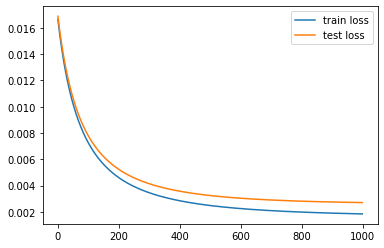

In [21]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [22]:
# Get accuracy
with torch.no_grad():
  p_train = model(X_train)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc = np.mean(y_train.cpu().numpy() == p_train)

  p_test = model(X_test)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc = np.mean(y_test.cpu().numpy() == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9998, Test acc: 0.9997


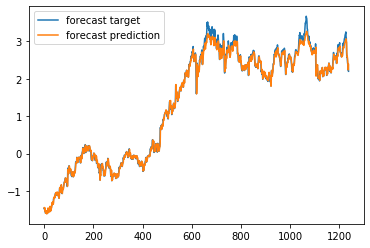

In [27]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()